## **Test Custom**

### **Table of Contents**


1. Libraries
2. Action Customization
   1. PPO
   2. DQN
3. Rewards Customization
   1. PPO
   2. DQN
4. Action + Reward Customization
   1. PPO
   2. DQN
5. Final Results

### **Libraries** 

In [1]:
# Algorithms
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DQN
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv

# Model evaluation
from stable_baselines3.common.evaluation import evaluate_policy 
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback


# hyperameters tuning
from sklearn.model_selection import ParameterGrid
from concurrent.futures import ThreadPoolExecutor, as_completed

# Wrappers 
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from gymnasium import RewardWrapper, ActionWrapper


# Graphs
import matplotlib.pyplot as plt


from stable_baselines3.common.logger import configure


from torch.utils.tensorboard import SummaryWriter

**Baseline Environment**

In [2]:
test_env = gym.make('Taxi-v3')

#### **Action Customization**

In [3]:
class CustomActionWrapper(ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        self.action_space = gym.spaces.Discrete(env.action_space.n + 4) # Adicionar 4 ações ao Espaço de Ações 

    def action(self, action):
        """Transform the custom action into a base action if necessary."""
        if action in [6, 7, 8, 9]:
            # Diagonal actions are handled in the `step` method.
            return None  # Indicate custom handling
        return action  # Pass through for base actions


    def step(self, action):
        grid_size = 5

        # Get the taxi position
        encoded_state = self.env.unwrapped.s
        
        taxi_row, taxi_col, pass_idx, dest_idx = self.env.unwrapped.decode(encoded_state)

        # Handle diagonal actions
        if action == 6:  # Move South-East
            new_row = min(taxi_row + 1, grid_size - 1)
            new_col = min(taxi_col + 1, grid_size - 1)
        elif action == 7:  # Move South-West
            new_row = min(taxi_row + 1, grid_size - 1)
            new_col = max(taxi_col - 1, 0)
        elif action == 8:  # Move North-East
            new_row = max(taxi_row - 1, 0)
            new_col = min(taxi_col + 1, grid_size - 1)
        elif action == 9:  # Move North-West
            new_row = max(taxi_row - 1, 0)
            new_col = max(taxi_col - 1, 0)
        else:
            # Pass through base actions to the original step method
            return super().step(action)

        # Validate the move (check for walls or invalid spaces)
        if self.env.unwrapped.desc[new_row, new_col] != b' ':  # Assume `b' '` indicates valid space
            # Invalid move, no state change
            reward = -1  # Same as base environment for invalid moves
            done = False
            obs = self.env.unwrapped.s
        else:
            # Update the state manually for diagonal actions
            self.env.unwrapped.s = self.env.unwrapped.encode(new_row, new_col, pass_idx, dest_idx)

            # Compute reward manually
            reward = -1  # Default reward for non-goal moves

            # Check if the new state is terminal
            done = self.env.unwrapped.s == self.env.unwrapped.encode(
                dest_idx // grid_size, dest_idx % grid_size, pass_idx, dest_idx
            )

            # Get updated observation
            obs = self.env.unwrapped.s

        truncated = False  # Taxi environment doesn't use truncation

        # Return updated information
        return obs, reward, done, truncated, {}


In [4]:
test_env = CustomActionWrapper(test_env)

**PPO**

In [7]:
from tqdm import tqdm  # Para criar uma barra de progresso

writer = SummaryWriter(log_dir="./tensorboard/ppo_action_test/")
num_episodes = 10_000  # Número de episódios para testar o modelo
model = PPO.load("models_custom/ppo_taxi_custom_action")  # Carregar o modelo treinado
all_rewards_ppo_action = []  # Lista para guardar as recompensas de cada episódio
all_steps_ppo_action = []  # Lista para guardar o número de passos de

# Testar o modelo em 1000 episódios com barra de progresso
with tqdm(total=num_episodes, desc="Testing Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        obs, _ = test_env.reset()  # Reiniciar o ambiente
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 200:
            action, _ = model.predict(obs, deterministic=True)  # Política determinística
            action = int(action)  # Converter ação para inteiro, se necessário
            obs, reward, done, _, _ = test_env.step(action)
            total_reward += reward
            steps += 1

        # Guardar os resultados
        all_rewards_ppo_action.append(total_reward)
        all_steps_ppo_action.append(steps)

        # Logar no TensorBoard
        writer.add_scalar("Test/Episode_Reward", total_reward, episode)
        writer.add_scalar("Test/Episode_Steps", steps, episode)

        # Atualizar a barra de progresso
        pbar.set_postfix({"Reward": total_reward, "Steps": steps})
        pbar.update(1)

# Fechar o TensorBoard Writer
writer.close()

# Exibir estatísticas finais
print(f"Average Reward over {num_episodes} episodes: {np.mean(all_rewards_ppo_action)}")
print(f"Average Steps over {num_episodes} episodes: {np.mean(all_steps_ppo_action)}")


Testing Episodes: 100%|██████████| 10000/10000 [01:21<00:00, 122.38it/s, Reward=10, Steps=11]  

Average Reward over 10000 episodes: -85.2406
Average Steps over 10000 episodes: 96.7297


**DQN**

In [10]:
from tqdm import tqdm  # Para criar uma barra de progresso

writer = SummaryWriter(log_dir="./tensorboard/dqn_action_test/")
num_episodes = 10_000  # Número de episódios para testar o modelo
model = DQN.load("models_custom/dqn_taxi_custom_action")  # Carregar o modelo treinado
all_rewards_dqn_action= []  # Lista para guardar as recompensas de cada episódio
all_steps_dqn_action = []  # Lista para guardar o número de passos de

# Testar o modelo em 1000 episódios com barra de progresso
with tqdm(total=num_episodes, desc="Testing Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        obs, _ = test_env.reset()  # Reiniciar o ambiente
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 200:
            action, _ = model.predict(obs, deterministic=True)  # Política determinística
            action = int(action)  # Converter ação para inteiro, se necessário
            obs, reward, done, _, _ = test_env.step(action)
            total_reward += reward
            steps += 1

        # Guardar os resultados
        all_rewards_dqn_action.append(total_reward)
        all_steps_dqn_action.append(steps)

        # Logar no TensorBoard
        writer.add_scalar("Test/Episode_Reward", total_reward, episode)
        writer.add_scalar("Test/Episode_Steps", steps, episode)

        # Atualizar a barra de progresso
        pbar.set_postfix({"Reward": total_reward, "Steps": steps})
        pbar.update(1)

# Fechar o TensorBoard Writer
writer.close()

# Exibir estatísticas finais
print(f"Average Reward over {num_episodes} episodes: {np.mean(all_rewards_dqn_action)}")
print(f"Average Steps over {num_episodes} episodes: {np.mean(all_steps_dqn_action)}")


Testing Episodes: 100%|██████████| 10000/10000 [00:11<00:00, 900.46it/s, Reward=14, Steps=7]


Average Reward over 10000 episodes: 9.9332
Average Steps over 10000 episodes: 11.0668


#### **Reward Customization**

In [11]:
class CustomRewardWrapper(RewardWrapper):
    def __init__(self, env, penalty=1.0):
        super().__init__(env)
        self.env = env
        self.visited_positions = set()  # Set to store visited positions
        self.penalty = penalty

    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        
        
        # Get the taxi position
        encoded_state = self.env.unwrapped.s
        
        taxi_row, taxi_col, pass_idx, dest_idx = self.env.unwrapped.decode(encoded_state)
        # Get the taxi's position (assuming obs contains the position as (x, y) coordinates)
        taxi_pos = (taxi_row, taxi_col)  # The position is stored in the first two elements of the observation

        # Check if the agent revisits a position
        if taxi_pos in self.visited_positions:
            # Apply a penalty if the taxi revisits a position
            reward -= self.penalty
        else:
           
            # Mark the current position as visited
            self.visited_positions.add(taxi_pos)

        # If the agent successfully picks up or drops off a passenger, we don't penalize
        if done and 'pickup' in info and info['pickup']:
            self.visited_positions.clear()  # Reset visited positions after task completion

        return obs, reward, done, _, info
    

In [14]:
test_env = CustomRewardWrapper(test_env)

**PPO**

In [16]:
from tqdm import tqdm  # Para criar uma barra de progresso

writer = SummaryWriter(log_dir="./tensorboard/ppo_rewards_test/")
num_episodes = 10_000  # Número de episódios para testar o modelo
model = PPO.load("models_custom/ppo_taxi_custom_rewards")  # Carregar o modelo treinado
all_rewards_ppo_reward= []  # Lista para guardar as recompensas de cada episódio
all_steps_ppo_reward= []  # Lista para guardar o número de passos de

# Testar o modelo em 1000 episódios com barra de progresso
with tqdm(total=num_episodes, desc="Testing Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        obs, _ = test_env.reset()  # Reiniciar o ambiente
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 200:
            action, _ = model.predict(obs, deterministic=True)  # Política determinística
            action = int(action)  # Converter ação para inteiro, se necessário
            obs, reward, done, _, _ = test_env.step(action)
            total_reward += reward
            steps += 1

        # Guardar os resultados
        all_rewards_ppo_reward.append(total_reward)
        all_steps_ppo_reward.append(steps)

        # Logar no TensorBoard
        writer.add_scalar("Test/Episode_Reward", total_reward, episode)
        writer.add_scalar("Test/Episode_Steps", steps, episode)

        # Atualizar a barra de progresso
        pbar.set_postfix({"Reward": total_reward, "Steps": steps})
        pbar.update(1)

# Fechar o TensorBoard Writer
writer.close()

# Exibir estatísticas finais
print(f"Average Reward over {num_episodes} episodes: {np.mean(all_rewards_ppo_reward)}")
print(f"Average Steps over {num_episodes} episodes: {np.mean(all_steps_ppo_reward)}")


Testing Episodes: 100%|██████████| 10000/10000 [00:26<00:00, 377.94it/s, Reward=-18, Steps=13]    


Average Reward over 10000 episodes: -65.3802
Average Steps over 10000 episodes: 24.6396


**DQN**

In [17]:
from tqdm import tqdm  # Para criar uma barra de progresso

writer = SummaryWriter(log_dir="./tensorboard/dqn_rewards_test/")
num_episodes = 10_000  # Número de episódios para testar o modelo
model = DQN.load("models_custom/dqn_taxi_custom_rewards")  # Carregar o modelo treinado
all_rewards_dqn_rewards= []  # Lista para guardar as recompensas de cada episódio
all_steps_dqn_rewards = []  # Lista para guardar o número de passos de

# Testar o modelo em 1000 episódios com barra de progresso
with tqdm(total=num_episodes, desc="Testing Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        obs, _ = test_env.reset()  # Reiniciar o ambiente
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 200:
            action, _ = model.predict(obs, deterministic=True)  # Política determinística
            action = int(action)  # Converter ação para inteiro, se necessário
            obs, reward, done, _, _ = test_env.step(action)
            total_reward += reward
            steps += 1

        # Guardar os resultados
        all_rewards_dqn_rewards.append(total_reward)
        all_steps_dqn_rewards.append(steps)

        # Logar no TensorBoard
        writer.add_scalar("Test/Episode_Reward", total_reward, episode)
        writer.add_scalar("Test/Episode_Steps", steps, episode)

        # Atualizar a barra de progresso
        pbar.set_postfix({"Reward": total_reward, "Steps": steps})
        pbar.update(1)

# Fechar o TensorBoard Writer
writer.close()

# Exibir estatísticas finais
print(f"Average Reward over {num_episodes} episodes: {np.mean(all_rewards_dqn_rewards)}")
print(f"Average Steps over {num_episodes} episodes: {np.mean(all_steps_dqn_rewards)}")


Testing Episodes: 100%|██████████| 10000/10000 [00:12<00:00, 787.28it/s, Reward=-21, Steps=14]


Average Reward over 10000 episodes: -18.2209
Average Steps over 10000 episodes: 13.0737


#### **Action + Reward Combination**

In [19]:
test_env = gym.make('Taxi-v3')
test_env = CustomActionWrapper(test_env)
test_env = CustomRewardWrapper(test_env)

**PPO**

In [20]:
from tqdm import tqdm  # Para criar uma barra de progresso

writer = SummaryWriter(log_dir="./tensorboard/ppo_combination_test/")
num_episodes = 10_000  # Número de episódios para testar o modelo
model = PPO.load("models_custom/ppo_taxi_custom_combination")  # Carregar o modelo treinado
all_rewards_ppo_combination = []  # Lista para guardar as recompensas de cada episódio
all_steps_ppo_combination = []  # Lista para guardar o número de passos de

# Testar o modelo em 1000 episódios com barra de progresso
with tqdm(total=num_episodes, desc="Testing Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        obs, _ = test_env.reset()  # Reiniciar o ambiente
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 200:
            action, _ = model.predict(obs, deterministic=True)  # Política determinística
            action = int(action)  # Converter ação para inteiro, se necessário
            obs, reward, done, _, _ = test_env.step(action)
            total_reward += reward
            steps += 1

        # Guardar os resultados
        all_rewards_ppo_combination.append(total_reward)
        all_steps_ppo_combination.append(steps)

        # Logar no TensorBoard
        writer.add_scalar("Test/Episode_Reward", total_reward, episode)
        writer.add_scalar("Test/Episode_Steps", steps, episode)

        # Atualizar a barra de progresso
        pbar.set_postfix({"Reward": total_reward, "Steps": steps})
        pbar.update(1)

# Fechar o TensorBoard Writer
writer.close()

# Exibir estatísticas finais
print(f"Average Reward over {num_episodes} episodes: {np.mean(all_rewards_ppo_combination)}")
print(f"Average Steps over {num_episodes} episodes: {np.mean(all_steps_ppo_combination)}")


Testing Episodes: 100%|██████████| 10000/10000 [01:29<00:00, 111.24it/s, Reward=3, Steps=9]       

Average Reward over 10000 episodes: -205.0173
Average Steps over 10000 episodes: 104.4866


**DQN**

In [23]:
from tqdm import tqdm  # Para criar uma barra de progresso

writer = SummaryWriter(log_dir="./tensorboard/dqn_combination/")
num_episodes = 10_000  # Número de episódios para testar o modelo
model = DQN.load("models_custom/dqn_taxi_custom_combination")  # Carregar o modelo treinado
all_rewards_dqn_combination = []  # Lista para guardar as recompensas de cada episódio
all_steps_dqn_combination = []  # Lista para guardar o número de passos de

# Testar o modelo em 1000 episódios com barra de progresso
with tqdm(total=num_episodes, desc="Testing Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        obs, _ = test_env.reset()  # Reiniciar o ambiente
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 200:
            action, _ = model.predict(obs, deterministic=True)  # Política determinística
            action = int(action)  # Converter ação para inteiro, se necessário
            obs, reward, done, _, _ = test_env.step(action)
            total_reward += reward
            steps += 1

        # Guardar os resultados
        all_rewards_dqn_combination.append(total_reward)
        all_steps_dqn_combination.append(steps)

        # Logar no TensorBoard
        writer.add_scalar("Test/Episode_Reward", total_reward, episode)
        writer.add_scalar("Test/Episode_Steps", steps, episode)

        # Atualizar a barra de progresso
        pbar.set_postfix({"Reward": total_reward, "Steps": steps})
        pbar.update(1)

# Fechar o TensorBoard Writer
writer.close()

# Exibir estatísticas finais
print(f"Average Reward over {num_episodes} episodes: {np.mean(all_rewards_dqn_combination)}")
print(f"Average Steps over {num_episodes} episodes: {np.mean(all_steps_dqn_combination)}")


Testing Episodes: 100%|██████████| 10000/10000 [00:11<00:00, 892.85it/s, Reward=-3, Steps=12]

Average Reward over 10000 episodes: -1.1666
Average Steps over 10000 episodes: 11.0833


### **Final Results**

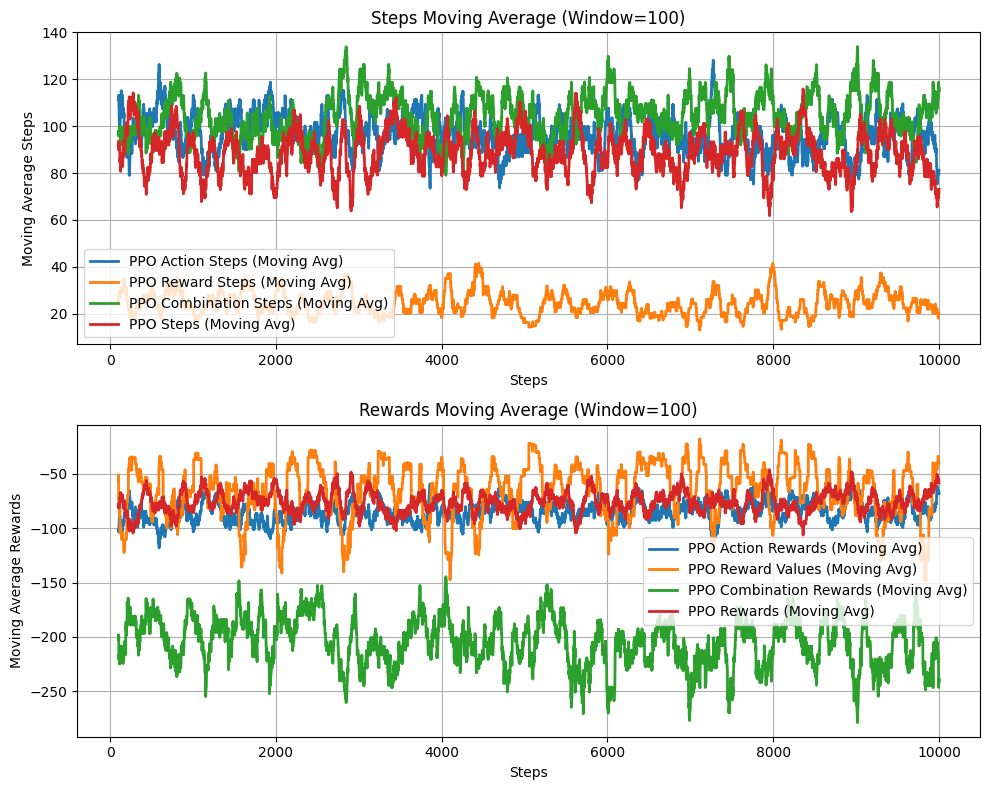

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Definir o tamanho da média móvel
rolling_window = 100

# Calcular a média móvel para os steps
ppo_action_steps_mean = pd.Series(all_steps_ppo_action).rolling(rolling_window).mean()
ppo_reward_steps_mean = pd.Series(all_steps_ppo_reward).rolling(rolling_window).mean()
ppo_combination_steps_mean = pd.Series(all_steps_ppo_combination).rolling(rolling_window).mean()
ppo_steps_mean = pd.Series(all_steps_ppo).rolling(rolling_window).mean()

# Calcular a média móvel das recompensas
ppo_action_rewards_mean = pd.Series(all_rewards_ppo_action).rolling(rolling_window).mean()
ppo_reward_rewards_mean = pd.Series(all_rewards_ppo_reward).rolling(rolling_window).mean()
ppo_combination_rewards_mean = pd.Series(all_rewards_ppo_combination).rolling(rolling_window).mean()
ppo_rewards_mean = pd.Series(all_rewards_ppo).rolling(rolling_window).mean()

# Criar os subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Primeiro subplot: Média móvel dos steps
ax[0].plot(ppo_action_steps_mean, label="PPO Action Steps (Moving Avg)", linewidth=2)
ax[0].plot(ppo_reward_steps_mean, label="PPO Reward Steps (Moving Avg)", linewidth=2)
ax[0].plot(ppo_combination_steps_mean, label="PPO Combination Steps (Moving Avg)", linewidth=2)
ax[0].plot(ppo_steps_mean, label="PPO Steps (Moving Avg)", linewidth=2)
ax[0].set_title(f"Steps Moving Average (Window={rolling_window})")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Moving Average Steps")
ax[0].legend()
ax[0].grid(True)

# Segundo subplot: Média móvel das recompensas
ax[1].plot(ppo_action_rewards_mean, label="PPO Action Rewards (Moving Avg)", linewidth=2)
ax[1].plot(ppo_reward_rewards_mean, label="PPO Reward Values (Moving Avg)", linewidth=2)
ax[1].plot(ppo_combination_rewards_mean, label="PPO Combination Rewards (Moving Avg)", linewidth=2)
ax[1].plot(ppo_rewards_mean, label="PPO Rewards (Moving Avg)", linewidth=2)
ax[1].set_title(f"Rewards Moving Average (Window={rolling_window})")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Moving Average Rewards")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


No gráfico do PPO, a configuração **Combination Rewards** apresentou o pior desempenho, com recompensas muito negativas e maior dificuldade em alcançar objetivos. As configurações **Action Rewards**, **Rewards** e **Reward Values** tiveram desempenho similar, mas nenhuma alcançou recompensas positivas consistentes. A configuração **Reward Values** destacou-se em passos menores, mas não necessariamente eficiente. 

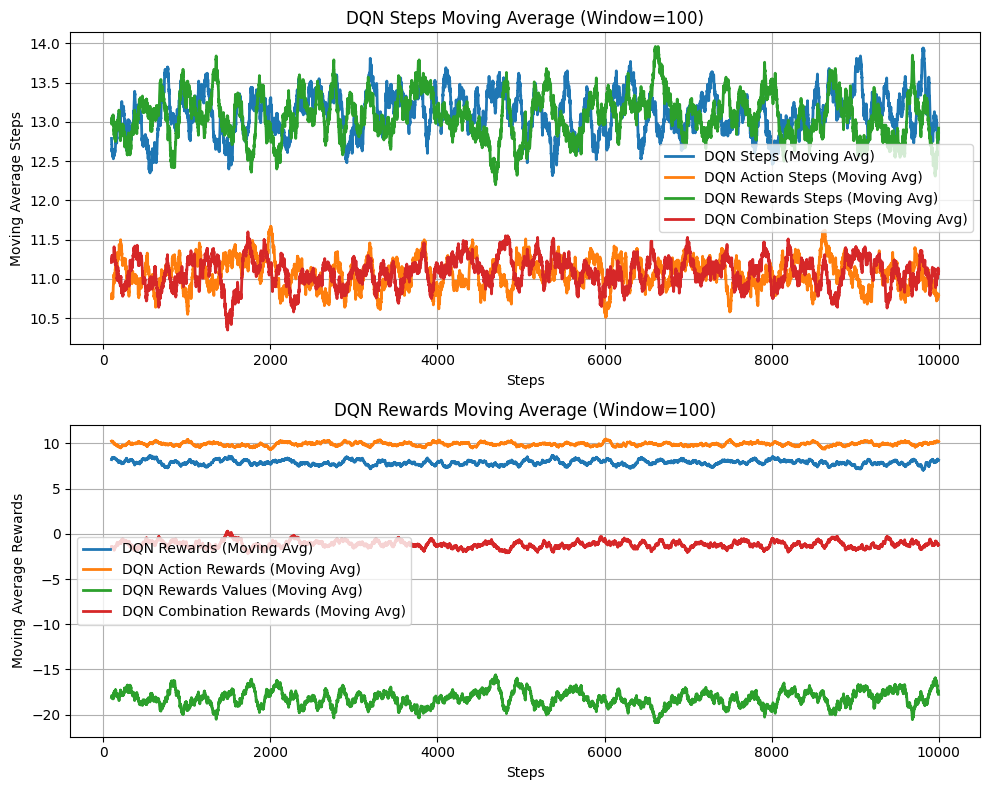

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Definir o tamanho da média móvel
rolling_window = 100

# Calcular a média móvel para os steps
dqn_steps_mean = pd.Series(all_steps_dqn).rolling(rolling_window).mean()
dqn_action_steps_mean = pd.Series(all_steps_dqn_action).rolling(rolling_window).mean()
dqn_rewards_steps_mean = pd.Series(all_steps_dqn_rewards).rolling(rolling_window).mean()
dqn_combination_steps_mean = pd.Series(all_steps_dqn_combination).rolling(rolling_window).mean()

# Calcular a média móvel das recompensas
dqn_rewards_mean = pd.Series(all_rewards_dqn).rolling(rolling_window).mean()
dqn_action_rewards_mean = pd.Series(all_rewards_dqn_action).rolling(rolling_window).mean()
dqn_rewards_rewards_mean = pd.Series(all_rewards_dqn_rewards).rolling(rolling_window).mean()
dqn_combination_rewards_mean = pd.Series(all_rewards_dqn_combination).rolling(rolling_window).mean()

# Criar os subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Primeiro subplot: Média móvel dos steps
ax[0].plot(dqn_steps_mean, label="DQN Steps (Moving Avg)", linewidth=2)
ax[0].plot(dqn_action_steps_mean, label="DQN Action Steps (Moving Avg)", linewidth=2)
ax[0].plot(dqn_rewards_steps_mean, label="DQN Rewards Steps (Moving Avg)", linewidth=2)
ax[0].plot(dqn_combination_steps_mean, label="DQN Combination Steps (Moving Avg)", linewidth=2)
ax[0].set_title(f"DQN Steps Moving Average (Window={rolling_window})")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Moving Average Steps")
ax[0].legend()
ax[0].grid(True)

# Segundo subplot: Média móvel das recompensas
ax[1].plot(dqn_rewards_mean, label="DQN Rewards (Moving Avg)", linewidth=2)
ax[1].plot(dqn_action_rewards_mean, label="DQN Action Rewards (Moving Avg)", linewidth=2)
ax[1].plot(dqn_rewards_rewards_mean, label="DQN Rewards Values (Moving Avg)", linewidth=2)
ax[1].plot(dqn_combination_rewards_mean, label="DQN Combination Rewards (Moving Avg)", linewidth=2)
ax[1].set_title(f"DQN Rewards Moving Average (Window={rolling_window})")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Moving Average Rewards")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


Os action steps do modelo DQN mostram-se mais eficientes, alcançando recompensas médias positivas e consistência no número de passos por episódio. Em contraste, os reward steps apresentam as piores recompensas, indicando dificuldades na aprendizagem. Comparado ao PPO, o DQN foi mais estável nas recompensas e nos passos. 